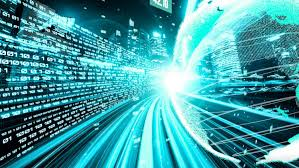

# **2024 Mineria de datos**


Integrantes:
*   Julieta Lopez Ceratto : L-3311/1
*   David Slepoy : S-5782/7



# Importar librerias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score,silhouette_samples
import time
import warnings
from warnings import WarningMessage
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# Punto 1



Carga de datos

In [2]:
df = pd.read_csv('./src/dxCropRecommendation.csv')

In [3]:
df

,Nitrogeno,Fosforo,Potasio,Temperatura,Humedad,pH,Lluvia,Cultivo
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Arroz
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Arroz
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Arroz
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Arroz
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Arroz
...,...,...,...,...,...,...,...,...
1595,107,34,32,26.774637,66.413269,6.780064,177.774507,Cafe
1596,99,15,27,27.417112,56.636362,6.086922,127.924610,Cafe
1597,118,33,30,24.131797,67.225123,6.362608,173.322839,Cafe
1598,117,32,34,26.272418,52.127394,6.758793,127.175293,Cafe


# Punto 2


## Análisis exploratorio de los datos

Se verifica que no haya datos null

In [4]:
df.isna().any()

Nitrogeno      False
Fosforo        False
Potasio        False
Temperatura    False
Humedad        False
pH             False
Lluvia         False
Cultivo        False
dtype: bool

Observamos los tipos de datos:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogeno    1600 non-null   int64  
 1   Fosforo      1600 non-null   int64  
 2   Potasio      1600 non-null   int64  
 3   Temperatura  1600 non-null   float64
 4   Humedad      1600 non-null   float64
 5   pH           1600 non-null   float64
 6   Lluvia       1600 non-null   float64
 7   Cultivo      1600 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 100.1+ KB


Creamos un df sin la columna cultivo ya que esta es una variable cualitativa

In [6]:
X_df = df.drop(columns=['Cultivo'], axis = 1)

Convertimos a float los datos int para trabajar con el mismo tipo de datos en todas las variables

In [7]:
X_df['Nitrogeno'] = X_df['Nitrogeno'].astype(float)
X_df['Fosforo'] = X_df['Fosforo'].astype(float)
X_df['Potasio'] = X_df['Potasio'].astype(float)

### Valores Atípicos

Visualizamos las variables en boxplot para chequear atípicos y su distribución

In [8]:
columnas = X_df.columns.tolist()

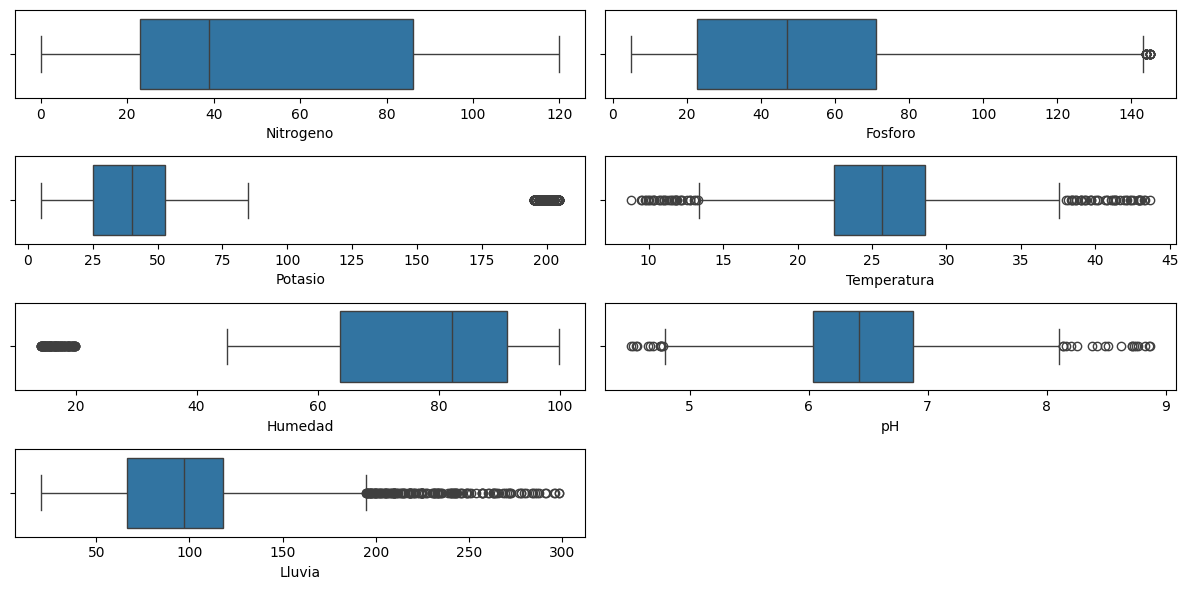

In [9]:
# Crear un lienzo con dos subplots uno al lado del otro
fig, axes = plt.subplots(4, 2, figsize=(12, 6))
k = 0
for i in range(0,4):
    for j in range(0,2):
      if k > len(columnas)-1:
        break
      else:
        # Seleccionar la columna correspondiente
            sns.boxplot(x=X_df[columnas[k]], ax=axes[i,j])
        # Incrementar el índice de la columna
            k += 1
#Quitamos ultimo cuadro ya que son 7 columnas
axes[3,1].axis('off')
plt.tight_layout()
plt.show()

Observamos a primera vista las distintas medidas de las columnas:

In [10]:
df.describe()

,Nitrogeno,Fosforo,Potasio,Temperatura,Humedad,pH,Lluvia
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,52.003750,53.145000,57.455625,25.627031,75.299276,6.474024,104.126884
std,35.697954,37.949247,56.440856,5.384785,20.534713,0.658380,56.235890
min,0.000000,5.000000,5.000000,8.825675,14.258040,4.507524,20.211267
25%,23.000000,22.750000,25.000000,22.481574,63.675620,6.034347,66.697864
50%,39.000000,47.000000,40.000000,25.662093,82.281131,6.423214,97.318949
75%,86.000000,71.000000,53.000000,28.568738,91.337228,6.873499,117.947585
max,120.000000,145.000000,205.000000,43.675493,99.981876,8.868741,298.560117


Podemos observar, entre los boxplot y el cuadro anterior que:
- Nitrógeno: no posee atípicos pero si una gran varianza como tal lo refleja su std en comparación con la media; su RIC se concentra en valores [23,86]. El rango es amplio, desde 0 hasta 120, lo que sugiere que hay situaciones tanto de escasez como de abundancia de Nitrógeno en las muestras.
- Fósforo: similar al nitrógeno en cuanto a variabilidad de los datos. Posee muy pocos valores atípicos, los cuales se encuentran luego del valor 150 aprox.
- Potasio: Posee muchos valores atípicos y gran variabilidad como se ve en su sdt de 56.44
- Temperatura: Su distribución es más uniforme a simple vista y tal como lo refleja su sdt; sin embargo, posee muchos valores atípicos.
- Humedad: similar a Temperatura en cuanto a su uniformidad a simple vista, sin embargo, sus valores atípicos se concentran en valores bajos.
- PH: Los valores de pH son bastante consistentes, con una desviación estándar baja. Tiene mayor variablidad que las dos anteriores. Posee valores atípicos tanto bajos como altos.
- Lluvia: La lluvia muestra una considerable variabilidad con un alto sdt (56.24). Sus valores atípicos son considerables, y se concentrar en altos.



Ahora bien, los datos "atípicos" observados en el boxplot pueden no ser tales y se puede estar tratando de distribuciones bimodales o de otros tipos que no se observan correctamente en un boxplot; por lo tanto, las visualizamos en histogramas.

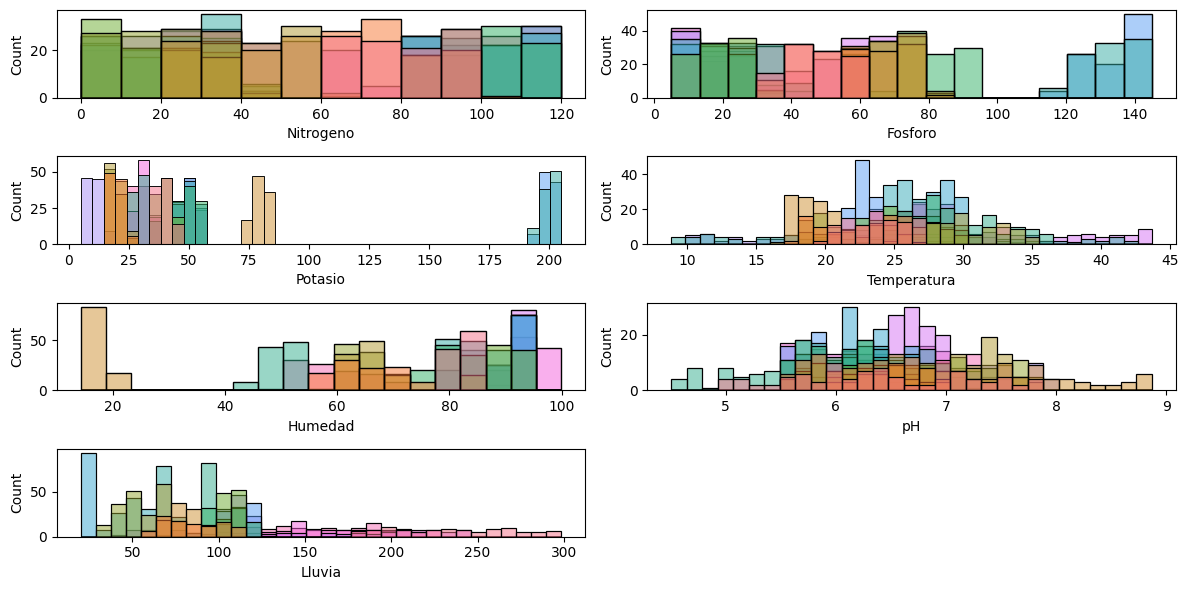

In [11]:
# Crear un lienzo con dos subplots uno al lado del otro
fig, axes = plt.subplots(4, 2, figsize=(12, 6))
k = 0
for i in range(0,4):
    for j in range(0,2):
      if k > len(columnas)-1:
        break
      else:
        # Seleccionar la columna correspondiente
            sns.histplot(x=df[columnas[k]], ax=axes[i,j], hue=df['Cultivo' ],legend = False)
        # Incrementar el índice de la columna
            k += 1
#Quitamos ultimo cuadro ya que son 7 columnas
axes[3,1].axis('off')
plt.tight_layout()
plt.show()

Observamos que:
Si bien al principio, visualizandolo en el boxplot, algunas columnas parecían tener atípicos, al visualizarla en el histograma con separación por cultivo, podemos observar que aquellos valores que en el conjunto total parecerían ser atípicos en realidad no lo son ya que son valores comunes para un tipo específico de cultivo.
Por ejemplo, en el caso del Fósforo, los valores bajos son normales para el cultivo Sandía.
Esto se ve con mas detalle haciendo un describe por cada cultivo a continuación.


In [12]:
cultivos = df['Cultivo'].unique()
def separar_cultivo(df):
    for cultivo in cultivos:
        df_cultivo = df[df['Cultivo'] == cultivo]
        #Imprimimos los cultivos con un resaltado para que sean más claros a simple vista
        print(f"\033[30;47m{cultivo}\033[0m.")
        print(df_cultivo.describe())
separar_cultivo(df)

Arroz.
        Nitrogeno     Fosforo     Potasio  Temperatura     Humedad  \
count  100.000000  100.000000  100.000000   100.000000  100.000000   
mean    79.890000   47.580000   39.870000    23.689332   82.272822   
std     11.917981    7.904966    2.946167     2.031272    1.418381   
min     60.000000   35.000000   35.000000    20.045414   80.122675   
25%     69.000000   41.000000   38.000000    21.927064   80.952094   
50%     80.000000   47.000000   40.000000    23.734837   82.189357   
75%     91.000000   54.250000   42.000000    25.513702   83.470254   
max     99.000000   60.000000   45.000000    26.929951   84.969072   

               pH      Lluvia  
count  100.000000  100.000000  
mean     6.425471  236.181114  
std      0.768692   34.291825  
min      5.005307  182.561632  
25%      5.869992  204.334023  
50%      6.363804  233.119859  
75%      7.039147  264.126903  
max      7.868475  298.560117  
Maiz.
       Nitrogeno     Fosforo   Potasio  Temperatura     Humedad     

### Correlaciones de variables

Visualizamos la correlación de variables.

<Axes: >

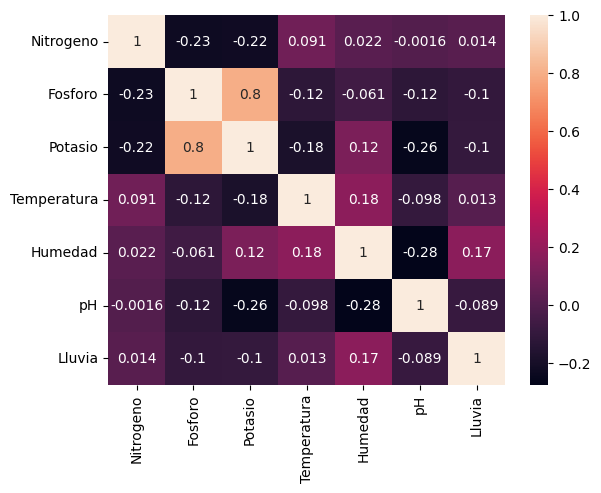

In [13]:
X_df.corr()
sns.heatmap(X_df.corr(), annot=True)

Se observa que las varibales entre sí no poseen correlación alguna, a excepción de Fósforo con Potasio, la cual tiene una correlación positiva de 0.8.

## Método de estandarización

El método de estandarización elegido es aquel denominado StandarScaler()

In [14]:
scaler = StandardScaler()
X_df_sdd = scaler.fit_transform(X_df)

In [15]:
X_df_sdd

array([[ 1.06471449, -0.29377354, -0.25619995, ...,  0.32654772,
         0.04400169,  1.75758833],
       [ 0.92460665,  0.12797403, -0.29164635, ...,  0.24455844,
         0.85702451,  2.17951492],
       [ 0.22406746,  0.04889636, -0.23847675, ...,  0.34203944,
         2.07571426,  2.84315472],
       ...,
       [ 1.84931839, -0.53100654, -0.48660156, ..., -0.39331825,
        -0.16928125,  1.23084365],
       [ 1.82129682, -0.55736577, -0.41570876, ..., -1.12877773,
         0.43266332,  0.40998043],
       [ 1.45701644, -0.92639489, -0.48660156, ..., -0.72596393,
         0.46463061,  0.65477164]])

# Punto 3

## PCA

Obtenemos las componentes:

In [16]:
pca = PCA(n_components= X_df_sdd.shape[1], random_state=1)
pca_features = pca.fit_transform(X_df_sdd)

pca_df_cultivo = pd.DataFrame(data = pca_features, columns= ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
pca_df_cultivo['Cultivo'] = df['Cultivo']

pca_df_cultivo

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Cultivo
0,-0.679163,0.601943,1.507909,1.364363,0.493099,0.238037,-0.047808,Arroz
1,-0.656053,0.269819,1.835039,1.063297,1.217446,0.691048,-0.230824,Arroz
2,-0.841368,-0.087601,2.592780,0.178132,1.840479,1.413747,0.008480,Arroz
3,-1.133296,0.755926,1.748575,0.370769,1.472582,0.428093,0.256406,Arroz
4,-1.054871,-0.063617,2.684205,0.901679,1.457319,1.260112,0.130674,Arroz
...,...,...,...,...,...,...,...,...
1595,-1.366382,0.212861,0.474935,1.112050,1.258054,-0.008156,0.202612,Cafe
1596,-1.388433,0.219093,-0.265467,0.999754,0.398982,-1.055571,0.423834,Cafe
1597,-1.253954,0.404922,0.508465,1.720013,0.802948,-0.332032,0.076794,Cafe
1598,-1.370180,-0.526139,-0.288492,1.382442,1.033344,-0.355455,0.318827,Cafe


Realizamos los Eigenvectors

In [17]:
pca_eigenvector = pd.DataFrame(data = pca.components_, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], index= ['X1','X2','X3','X4','X5','X6','X7'])
pca_eigenvector

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
X1,-0.296443,0.625032,0.650819,-0.190099,0.044150,-0.220592,-0.105562
X2,0.122810,-0.070205,0.064990,0.384781,0.635231,-0.546338,0.354550
X3,-0.338649,-0.092112,-0.062606,-0.523805,0.039403,0.102180,0.765864
X4,0.826894,0.054688,0.128699,-0.501026,-0.066328,-0.191076,0.068966
X5,0.280129,0.383445,0.132670,0.521265,-0.330188,0.342751,0.508603
X6,0.141882,0.069053,0.144256,-0.089348,0.674462,0.693031,-0.105438
X7,-0.000425,-0.664179,0.716461,0.103472,-0.157026,0.090185,0.045313


Observamos la varianza acumulada

In [18]:
# Creamos una función para acumular la varianza
def acumular(numeros):
     sum = 0
     var_c = []
     for num in numeros:
        sum += num
        var_c.append(sum)
     return var_c

In [19]:
var_c = acumular(pca.explained_variance_ratio_)
var_c

[0.2904645055355281,
 0.4995196512915329,
 0.6427095607656279,
 0.7705288738906559,
 0.8772185598996391,
 0.9759758120611615,
 1.0]

Observamos la varianza de cada PCA

In [20]:
pca_var_c = pd.DataFrame({'Eigenvalues': pca.explained_variance_, 'Proporcion de varianza explicada': pca.explained_variance_ratio_, 'Prop. acumulada de varianza':var_c})
pca_var_c

,Eigenvalues,Proporcion de varianza explicada,Prop. acumulada de varianza
0,2.034523,0.290465,0.290465
1,1.464301,0.209055,0.499520
2,1.002956,0.143190,0.642710
3,0.895295,0.127819,0.770529
4,0.747295,0.106690,0.877219
5,0.691733,0.098757,0.975976
6,0.168274,0.024024,1.000000


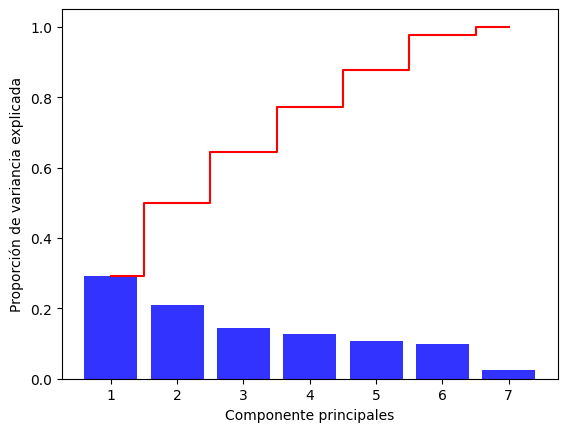

In [21]:
plt.bar(
    range(1,8),
    pca.explained_variance_ratio_,
    alpha = 0.8,
    align= 'center',
    color = 'blue',

    )
plt.step(
    range(1,8),
    np.cumsum(pca.explained_variance_ratio_),
    where = 'mid',
    color = 'r'
)
plt.ylabel('Proporción de variancia explicada')
plt.xlabel('Componente principales')
plt.show()

## Componentes principales elegidas según criterio de varianza acumulada(~75% -80%)​​

De acuerdo a dicho criterio, las componentes principales elegidas son PC1, PC2, PC3 y PC4.

<Axes: >

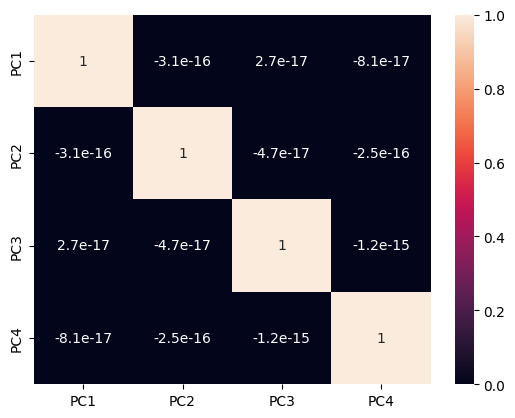

In [22]:
#Correlacion de componentes elegidas.
pca_df_cultivo[['PC1', 'PC2', 'PC3', 'PC4']].corr()
sns.heatmap(pca_df_cultivo[['PC1', 'PC2', 'PC3', 'PC4']].corr(), annot=True)

Podemos observar que no tienen correlación ya que son ortogonales entre si.

## Visualización de varianza

In [23]:
#Scatterplot
features = df.drop('Cultivo', axis = 1)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(pca_features, x = 0 , y = 1, color = pca_df_cultivo['Cultivo'], labels = {'color' : 'Cultivo'})

for i, feature in enumerate(features):
    fig.add_shape(
        type= 'line',
        x0 = 0, y0 = 0,
        x1 = loadings[i,0]*4.5,
        y1 = loadings[i,1]*4.5
    )
    fig.add_annotation(
        x=loadings[i, 0]*5.5,
        y=loadings[i, 1]*5.5,
        ax=0, ay=0,
        xanchor='center',
        yanchor='bottom',
        text=feature,
    )

fig.update_layout(title = "Biplot",width = 1200,height = 600)
fig.show()

In [24]:
fig = px.scatter_3d(pca_features, x=0, y=1, z=2,
                    color=pca_df_cultivo["Cultivo"],  labels={'color': 'Cultivo'})
fig.show()

Se puede observar que arroja ciertos grupos con distintas cercanías entre sí que refleja la similitud entre los distintos cultivos.
Se presenta una especie de "nube" central formada por todos los cultivos menos uva (rosa) y manzana (rojo).
Esto indica que PCA encuentra cierta similitud entre los cultivos que pertenecen a la nube central pero no entre manzana y uva y estos.
A su vez, encuentra similitud entre estas últimas 2.

# Punto 4

Aplicar Isomap y analizar los resultados obtenidos variando el numero de vecinos y componentes. Realizar un grafico en 2D de utilizando dos componentes.


## Estandarizacion

In [25]:
X_df_sdd

array([[ 1.06471449, -0.29377354, -0.25619995, ...,  0.32654772,
         0.04400169,  1.75758833],
       [ 0.92460665,  0.12797403, -0.29164635, ...,  0.24455844,
         0.85702451,  2.17951492],
       [ 0.22406746,  0.04889636, -0.23847675, ...,  0.34203944,
         2.07571426,  2.84315472],
       ...,
       [ 1.84931839, -0.53100654, -0.48660156, ..., -0.39331825,
        -0.16928125,  1.23084365],
       [ 1.82129682, -0.55736577, -0.41570876, ..., -1.12877773,
         0.43266332,  0.40998043],
       [ 1.45701644, -0.92639489, -0.48660156, ..., -0.72596393,
         0.46463061,  0.65477164]])

## ISOMAP

In [26]:
warnings.filterwarnings('ignore')
isomap = Isomap(n_neighbors=6, n_components=2)
isomap_features = isomap.fit_transform(X_df_sdd)

In [27]:
warnings.filterwarnings('ignore')
isomap.fit(X_df_sdd)
manifold_2da = isomap.transform(X_df_sdd)
manifold_2d = pd.DataFrame(manifold_2da, columns = ['Componente 1', 'Componente 2'])
manifold_2d['Cultivo'] = df['Cultivo'].to_numpy()
groups = manifold_2d.groupby('Cultivo')

Se elige el parámetro vecinos = 6, ya que es el que mejor visualización que los grupos permite.

Con parámetro de vecinos más bajos como 3: el algoritmo prioriza las relaciones locales, lo que resulta en grupos muy compactos y bien separados. Sin embargo, la estructura global puede perderse, y algunos grupos pueden parecer artificialmente alejados entre sí. Las relaciones a largo alcance (entre puntos más distantes) pueden no capturarse adecuadamente, lo que puede fragmentar grupos grandes en clusters más pequeños, o incluso producir varios subgrupos.

Con parámetro de vecinos más alto como 10: A diferencia del caso con vecinos = 3, los clusters parecen estar más cohesionados y claramente separados. Al aumentar el número de vecinos, se preservan más relaciones a mayor distancia, lo que evita que los clusters se fragmenten en subgrupos pequeños. Sin embargo, ya que es un número cercano a la cantidad de cultivos, las relaciones locales pueden diluirse o perderse. Lo que provoca que grupos que tienen pequeñas diferencias entre ellos, pero que son importantes, aparezcan más cercanos de lo que realmente son en el espacio de alta dimensionalidad.

Finalmente con K = 6: podemos observar una representación intermedia en términos de captura de relaciones locales y globales, en comparación con los gráficos de K=3 y K=10. La elección de 6 vecinos presenta un equilibrio entre mantener la estructura local sin perder demasiada información global.

La elección de K=6 en este Isomap parece ofrecer un buen compromiso entre capturar relaciones locales y globales. Los clusters están más definidos que en K=3, pero sin la cohesión forzada que vimos en K=10.

## Grafico 2D de 2 componentes

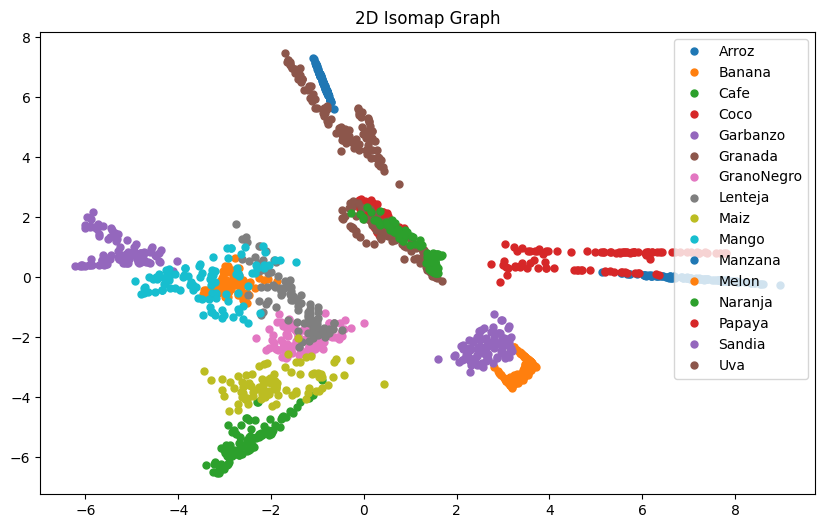

In [28]:
plt.figure(figsize=(10, 6))
plt.title('2D Isomap Graph')
for name, group in groups:
    plt.plot(group['Componente 1'], group['Componente 2'], marker='o', linestyle='', markersize=5, label=name)

plt.legend()
plt.show()

Se observan varios grupos o clústeres de puntos, lo que indica que las observaciones correspondientes a cada clase tienden a agruparse cerca entre sí.
Grupos como Uva(Marrón) y  Manzana (Azul oscuro) están más separados pero juntos entre sí, lo que sugiere que comparten similiradidades.
El grupo de rojo oscuro (Coco o Papaya) y Arroz, están más separados que el resto al igual que los dos anteriores, pero a la vez menos concentrados.
Banana (Naranja) y Sandía o Garbanzo (Naranja) están cerca una de la otra, lo que podría sugerir que estas dos clases tienen características similares en las dimensiones originales.

Por otro lado, hay cultivos que tienen similitudes con muchos otros cultivos, lo que hace que se forme una nube de puntos multicolor abajo a la izquierda.

# Punto 5

Aplicar t-SNE y analizar los resultados obtenidos variando el número de iteraciones, componentes y perplejidad. Realizar un gráfico en 2D de utilizando dos componentes.

In [29]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X_df_sdd)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.002s...
[t-SNE] Computed neighbors for 1600 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.539944
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.104248
[t-SNE] KL divergence after 1000 iterations: 0.380838


In [30]:
subset_dfTSNE = pd.DataFrame(df['Cultivo'])
subset_dfTSNE['tsne-2d-one'] = tsne_results[:,0]
subset_dfTSNE['tsne-2d-two'] = tsne_results[:,1]

Se probaron distintos parámetros de perplexity (10,20,30,40), manteniendo 1000 iteraciones y se encontró que el que deja visualizar los conjuntos bien definidos es

Imagen perplejidad 10

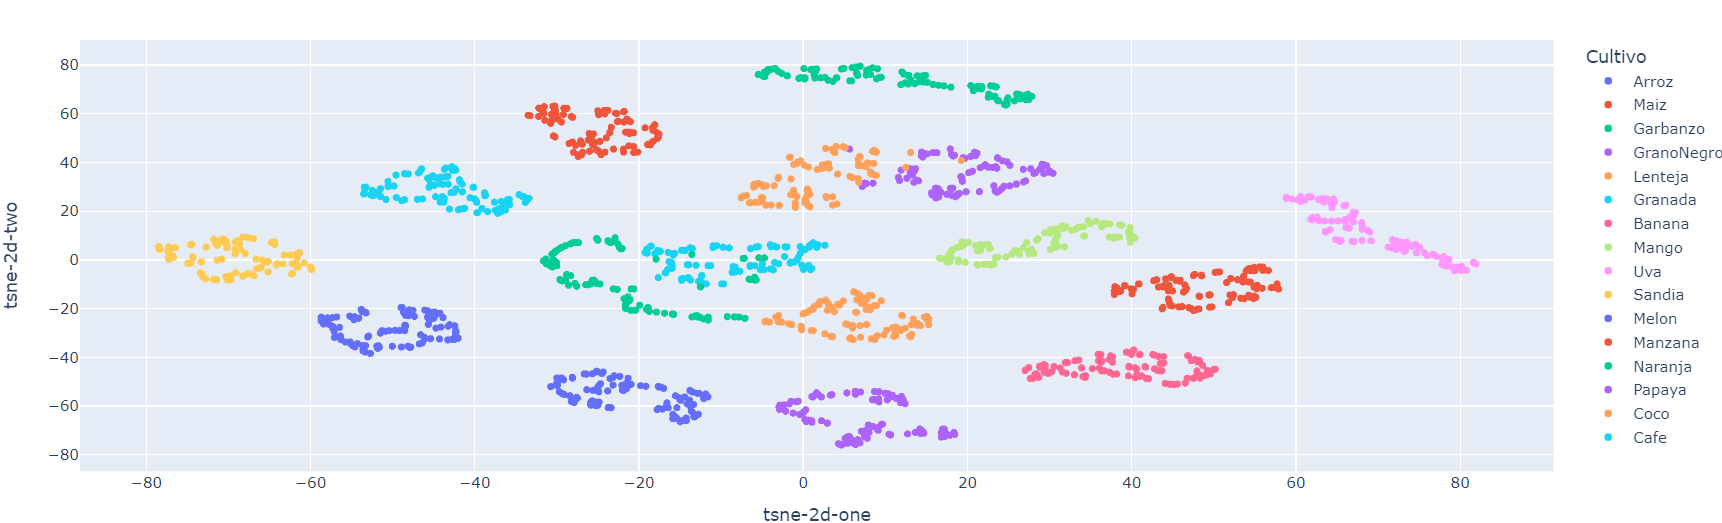

Imagen perplejidad 20

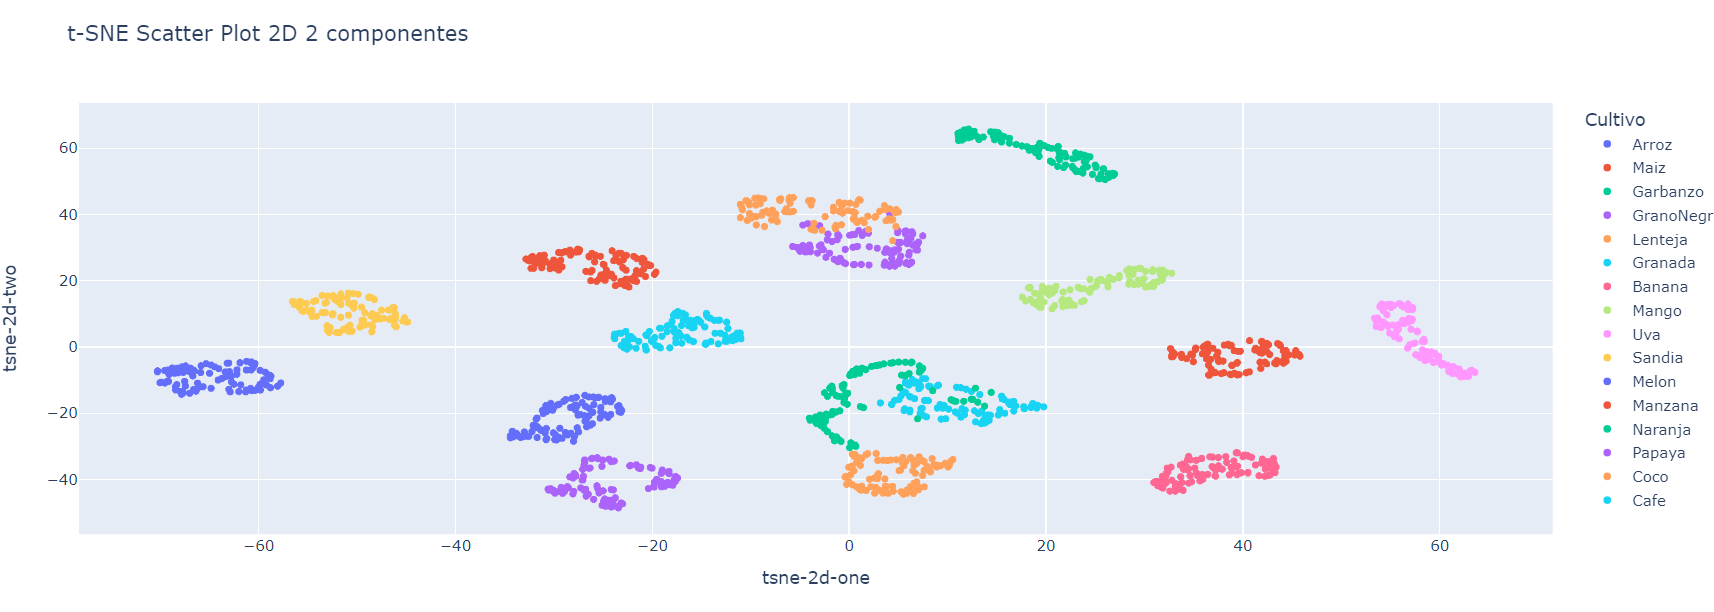

Imagen perplejidad 30

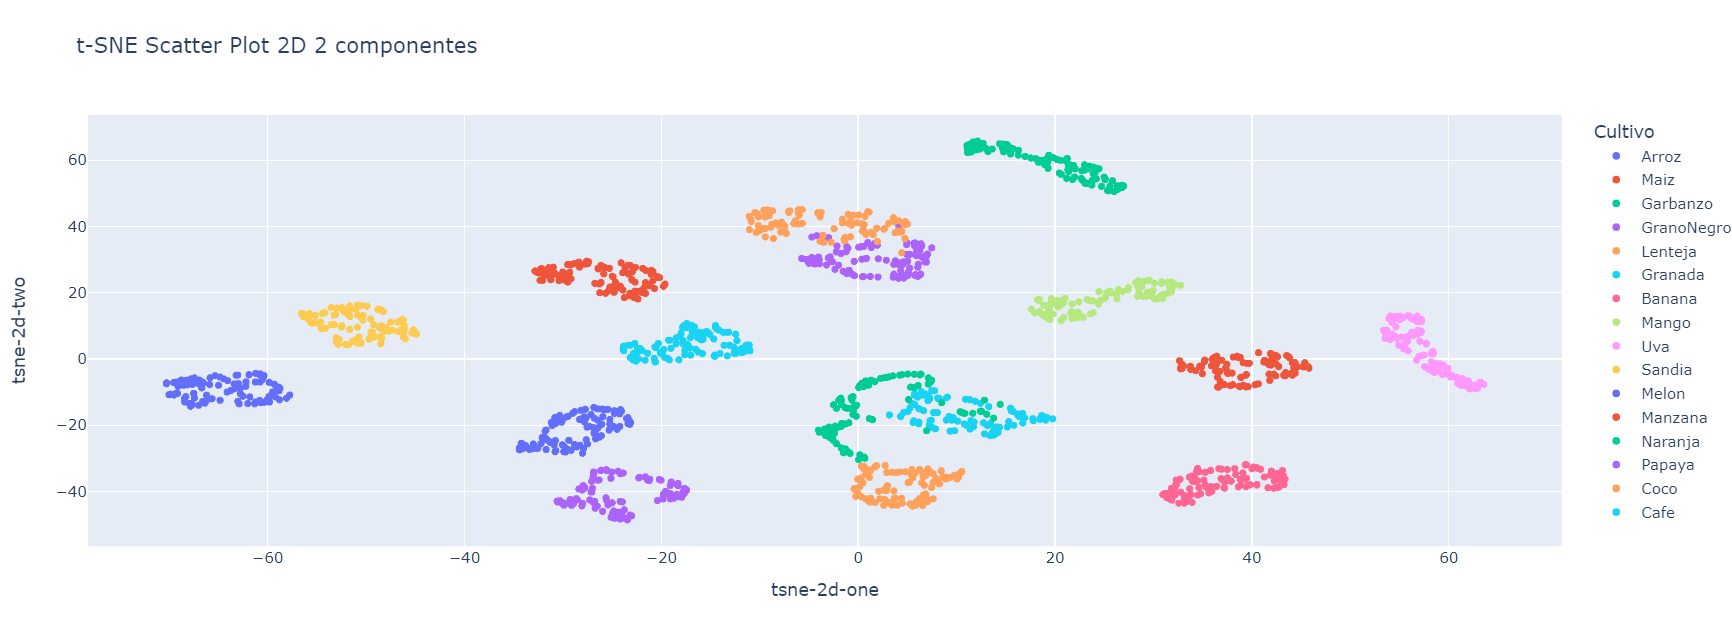

## Visualizacion 2D con 2 componentes

In [31]:
fig = px.scatter(
    subset_dfTSNE,
    x="tsne-2d-one",
    y="tsne-2d-two",
    color="Cultivo",  # Usa "Cultivo" para diferenciar por color
    hover_name="Cultivo",  # Muestra "Cultivo" al pasar el cursor
    title="t-SNE Scatter Plot 2D 2 componentes"
)

fig.show()


El algoritmo ha proyectado los datos en 2D de manera que los puntos que son similares en las dimensiones originales tienden a agruparse en estas nuevas dimensiones SIN PRESERVAR LAS DISTANCIAS ORIGINALES (chequear con teoría).

Se observa una clara formación de clústeres bien diferenciados, lo que sugiere que las relaciones entre las clases están bien capturadas por el T-SNE bajo los parámetros pasados.

Algunas clases, como Melon (azul) y Sandía (amarillo), están bastante separadas de las demás, lo que sugiere que estas clases tienen características muy distintivas en los datos originales; lo mismo sucede con Lenteja(Naranja) y Grano Negro (Violeta).
En cuanto a Banana, esta parece no tener similaridades en cuanto características con los datos en la dimensión original ya que se encuentra bien separada de los demás cultivos.


# Suconjunto

Ahora, realizar un subconjunto de los datos considerando solo las frutas: Granada, Banana, Mango, Uva, Sandia, Melón, Manzana, Papaya y Coco.


In [32]:
df_sub = df[df['Cultivo'].isin(['Granada', 'Banana', 'Mango', 'Uva', 'Sandia', 'Melon', 'Manzana', 'Papaya', 'Coco'])]
df_sub.reset_index(drop=True, inplace=True)
escaler_sub = StandardScaler()
X_sub_sdd = escaler_sub.fit_transform(df_sub.drop('Cultivo', axis=1))

# Punto 6

Realizar nuevamente PCA y graficar las componentes de PCA en un gráfico 2D con sus respectivas clases.

In [33]:
pca_sub = PCA(n_components= X_sub_sdd.shape[1], random_state=3)
pca_features_sub = pca_sub.fit_transform(X_sub_sdd)

pca_df_cultivo_sub = pd.DataFrame(data = pca_features_sub, columns= ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
pca_df_cultivo_sub['Cultivo'] = df_sub['Cultivo']

pca_df_cultivo_sub

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Cultivo
0,0.013648,-0.835077,0.743881,-1.068993,-0.105067,-0.904683,-0.337077,Granada
1,0.155625,-0.558184,0.655660,-1.856469,0.020863,-0.594619,-0.276131,Granada
2,-0.195709,0.263186,1.185266,-1.530642,1.412123,-0.050441,-0.338990,Granada
3,-0.601758,0.186852,1.041343,-0.809731,0.132130,-0.339663,-0.068466,Granada
4,-0.246150,-0.058401,1.349298,-1.007603,1.239832,-0.402954,-0.352133,Granada
...,...,...,...,...,...,...,...,...
895,-0.344142,-1.810109,1.737064,-0.550841,-1.343527,-0.255568,0.342123,Coco
896,-0.286967,-1.607410,1.459550,-0.262884,-1.136217,-0.047847,0.102678,Coco
897,-0.360825,-1.026673,1.132937,-0.724633,-0.664020,-0.405115,-0.136085,Coco
898,-0.504782,-0.953091,1.010582,-0.929345,-1.018201,-0.342162,0.236672,Coco


In [34]:
pca_eigenvector_sub = pd.DataFrame(data = pca_sub.components_, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], index= ['X1','X2','X3','X4','X5','X6','X7'])
pca_eigenvector_sub

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
X1,-0.351038,0.579933,0.606158,-0.319110,0.060152,-0.248735,0.075520
X2,0.491330,0.118731,0.209816,-0.282642,0.458256,0.421668,-0.482479
X3,-0.269075,-0.076213,-0.080879,-0.048893,0.601467,0.402517,0.623759
X4,0.153478,0.401592,0.229254,0.843610,0.010784,0.217123,0.060617
X5,-0.468850,-0.028677,0.076842,-0.083651,-0.460748,0.711944,-0.217491
X6,0.522059,0.345250,-0.125977,-0.310158,-0.436005,0.209162,0.512191
X7,0.216898,-0.602060,0.712514,0.031906,-0.148712,0.023468,0.243144


In [35]:
pca_var_c_sub = pd.DataFrame({'Eigenvalues': pca_sub.explained_variance_, 'Proporcion de varianza explicada': pca_sub.explained_variance_ratio_, 'Prop. acumulada de varianza':var_c})
pca_var_c_sub

,Eigenvalues,Proporcion de varianza explicada,Prop. acumulada de varianza
0,2.301151,0.328371,0.290465
1,1.511554,0.215696,0.499520
2,1.305075,0.186232,0.642710
3,0.849638,0.121242,0.770529
4,0.637470,0.090966,0.877219
5,0.350614,0.050032,0.975976
6,0.052284,0.007461,1.000000


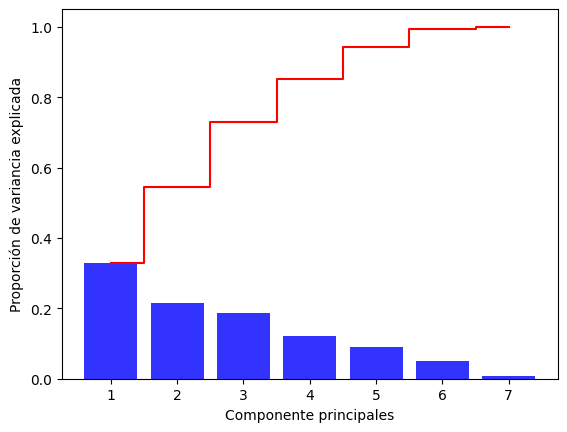

In [36]:
plt.bar(
    range(1,8),
    pca_sub.explained_variance_ratio_,
    alpha = 0.8,
    align= 'center',
    color = 'blue',

    )
plt.step(
    range(1,8),
    np.cumsum(pca_sub.explained_variance_ratio_),
    where = 'mid',
    color = 'r'
)
plt.ylabel('Proporción de variancia explicada')
plt.xlabel('Componente principales')
plt.show()

<Axes: >

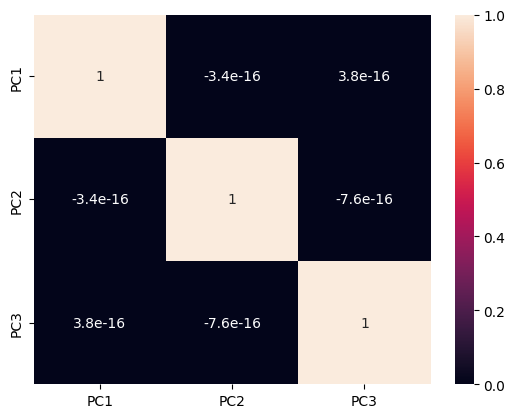

In [37]:
#Con el criterio de varianza acumulada >= 75% las componentes elegidas son PC1, PC2, PC3

#Correlacion de componentes elegidas.
pca_df_cultivo_sub[['PC1', 'PC2', 'PC3']].corr()
sns.heatmap(pca_df_cultivo_sub[['PC1', 'PC2', 'PC3']].corr(), annot=True)

Como se puede observar, la matriz de correlación arroja valores ínfimos en cuanto a la correlación entre los Componentes Principales (PC) lo cual es correcto.

In [38]:
#Scatterplot
features = pca_df_cultivo_sub.drop('Cultivo', axis = 1)

loadings = pca_sub.components_.T * np.sqrt(pca_sub.explained_variance_)

fig = px.scatter(pca_features_sub, x = 0 , y = 1, color = pca_df_cultivo_sub['Cultivo'], labels = {'color' : 'Cultivo'})

for i, feature in enumerate(features):
    fig.add_shape(
        type= 'line',
        x0 = 0, y0 = 0,
        x1 = loadings[i,0]*4.5,
        y1 = loadings[i,1]*4.5
    )
    fig.add_annotation(
        x=loadings[i, 0]*5.5,
        y=loadings[i, 1]*5.5,
        ax=0, ay=0,
        xanchor='center',
        yanchor='bottom',
        text=feature,
    )

fig.update_layout(title = "Biplot",width = 900,height = 600)
fig.show()

In [39]:
fig = px.scatter_3d(pca_features_sub, x=0, y=1, z=2,
              color=pca_df_cultivo_sub["Cultivo"],  labels={'color': 'Cultivo'})
fig.show()

La agrupación de puntos de un mismo color sugiere similitudes en las características representadas por las componentes principales. Se puede observar:
- Banana (en rojo), Sandía (en naranja), Papaya (verde claro), Coco (en rosa), Melón (Celeste) y Granada (Violeta oscuro) parecen formar grupos más o menos definidos, lo que indica que los datos asociados a esos cultivos son similares entre sí.
- Mango (Verde agua) se presenta como un grupo separado, lo que indica que no comparte tantas similaridades con los anteriores.
- Manzana (turquesa) y Uva (violeta clara) son similares entre sí, pero bastante distintas con los otros grupos.

# Punto 7

Aplicar K-means y analizar los resultados obtenidos variando el número de clusters y
obtener el número óptimo de clusters mediante GAP. Realizar un gráfico en 3D de
utilizando tres atributos de los datos y donde los colores estén asociados a los clusters.

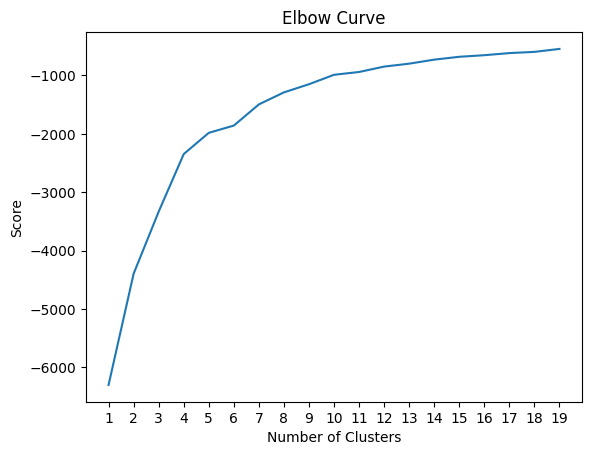

In [40]:
# Ignorar todas las advertencias
warnings.filterwarnings("ignore", category=FutureWarning)

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X_sub_sdd).score(X_sub_sdd) for i in range(len(kmeans))]

plt.plot(Nc, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

# Configura las marcas del eje x para que vayan de 1 en 1
plt.xticks(np.arange(1, 20, 1))

plt.show()

Se elige k = 4 ya que allí se quiebra el codo

In [41]:
warnings.filterwarnings("ignore", category=FutureWarning)
k_means = KMeans(n_clusters=4, random_state=1)
k_means.fit(X_sub_sdd)

KMeans(n_clusters=4, random_state=1)

In [42]:
df_X_sub_sdd = pd.DataFrame(X_sub_sdd, columns=df_sub.drop('Cultivo', axis=1).columns)
df_X_sub_sdd['Cultivo'] = df_sub['Cultivo']

In [43]:
# El metodo labels_ nos da a que cluster corresponde cada observacion
df_X_sub_sdd['Cluster KMeans'] = k_means.labels_
df_X_sub_sdd.groupby(['Cultivo','Cluster KMeans']).mean()

Nitrogeno   Fosforo   Potasio  Temperatura   Humedad  \
Cultivo Cluster KMeans                                                         
Banana  2                1.306333  0.549698 -0.423305     0.082513 -0.305575   
Coco    1               -0.750327 -0.833925 -0.719074     0.088509  0.789621   
Granada 1               -0.832067 -0.795232 -0.572861    -0.921064  0.432868   
Mango   1               -0.800527 -0.616007 -0.729257     0.776810 -2.588901   
Manzana 3               -0.781341  1.659701  1.854090    -0.777366  0.599790   
Melon   2                1.308698 -0.817130 -0.422849     0.315566  0.600502   
Papaya  1               -0.102108  0.052525 -0.432207     1.225511  0.598532   
        2                0.091261  0.073060 -0.412320     1.241410  0.613420   
Sandia  2                1.285043 -0.832437 -0.420721    -0.240908  0.057490   
Uva     0               -0.724248  1.610141  1.856606     1.422540 -0.171856   
        3               -0.715715  1.631438  1.857899    -1.669815 -0.201577   

                              pH    Lluvia  
Cultivo Cluster KMeans                      
Banana  2              -0.432157  0.132069  
Coco    1              -0.447549  1.570338  
Granada 1               0.502684  0.190796  
Mango   1              -0.888831 -0.068764  
Manzana 3              -0.546011  0.294554  
Melon   2               0.354953 -1.485880  
Papaya  1               1.155186  1.892955  
        2               1.162218 -0.360993  
Sandia  2               0.642521 -0.957684  
Uva     0              -0.530076 -0.571544  
        3              -0.239159 -0.579519

In [44]:
observaciones_por_cluster = df_X_sub_sdd['Cluster KMeans'].value_counts().sort_index()
observaciones_por_fruta = df_X_sub_sdd['Cultivo'].value_counts().sort_index()
pd.concat([observaciones_por_cluster,observaciones_por_fruta], axis = 0)

0           36
1          356
2          344
3          164
Banana     100
Coco       100
Granada    100
Mango      100
Manzana    100
Melon      100
Papaya     100
Sandia     100
Uva        100
Name: count, dtype: int64

Se puede observar que agrupa en menos clases que las frutas en el df como era de esperar, junta Poroto Negro y Granada (cluster 0), Arroz con Banana y Mango (cluster 1), Banana con Lentejas, Melón y Maiz (cluster 2), Garbanzos solo (cluster 3).
La "diferencia" es que divide el cultivo "Banana" en dos clusters, en vez de poner todos los datos asociados a dicha fruta dentro de un mismo clúster.
Cambiarlo


In [45]:
fig = px.scatter_3d(pca_features_sub, x=0, y=1, z=2,
              color=df_X_sub_sdd["Cluster KMeans"],  labels={'color': 'Cluster KMeans',},hover_data={'Cultivo': df_X_sub_sdd["Cultivo"]} )
fig.show()

# Punto 8

Aplicar clustering jerárquico y determinar cuál número sería el que mejor represente los
datos. Utilizar el score de Silhouette y calcular el número óptimo de cluster por medio de
GAP.

In [46]:
Z = linkage(X_sub_sdd, method='ward')

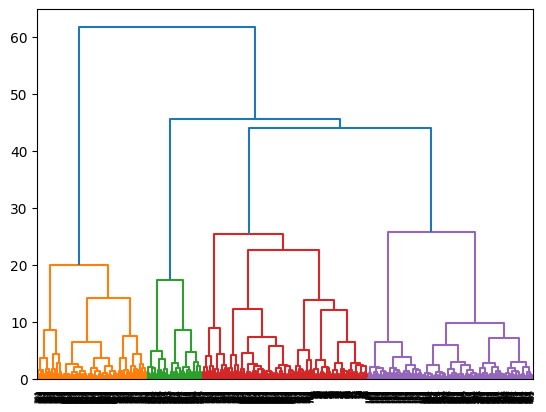

In [47]:
dendrogram(Z)
plt.show()

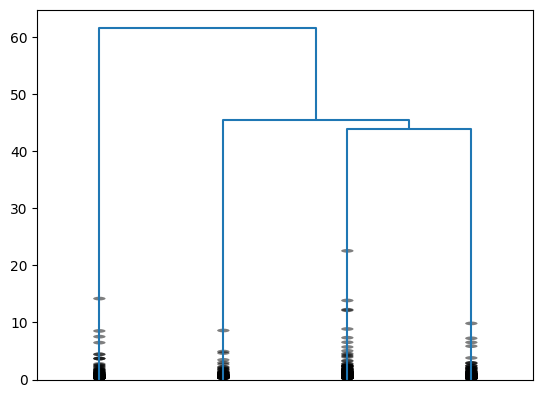

In [48]:
dendrogram(Z,  truncate_mode = 'lastp', p = 4, show_leaf_counts = False, show_contracted = True)
plt.axhline(y=110, c='k', linestyle='dashed')
plt.show()

### GAP

In [49]:
def calculate_intra_cluster_dispersion(X_scaled, k, linkage='ward'):
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = clustering.fit_predict(X_scaled)
    centroids = np.array([np.mean(X_scaled[labels == i], axis=0) for i in range(k)])
    intra_cluster_dispersion = np.sum(np.linalg.norm(X_scaled[labels] - centroids[labels], axis=1)**2)
    return intra_cluster_dispersion

In [50]:
gaps = []
max_k = 20
for k in range(1, max_k + 1):
    real_inertia = calculate_intra_cluster_dispersion(X_sub_sdd, k, linkage='ward')
    inertia_list = []
    for _ in range(10):
      random_data = np.random.rand(*X_sub_sdd.shape)
      intra_cluster_dispersion = calculate_intra_cluster_dispersion(random_data, k)
      inertia_list.append(intra_cluster_dispersion)

    reference_inertia = np.mean(inertia_list)

    gap = np.log(reference_inertia) - np.log(real_inertia)
    gaps.append(gap)

optimal_k = np.argmax(gaps) + 1

Número óptimo de clusters según el Gap Statistic: 1


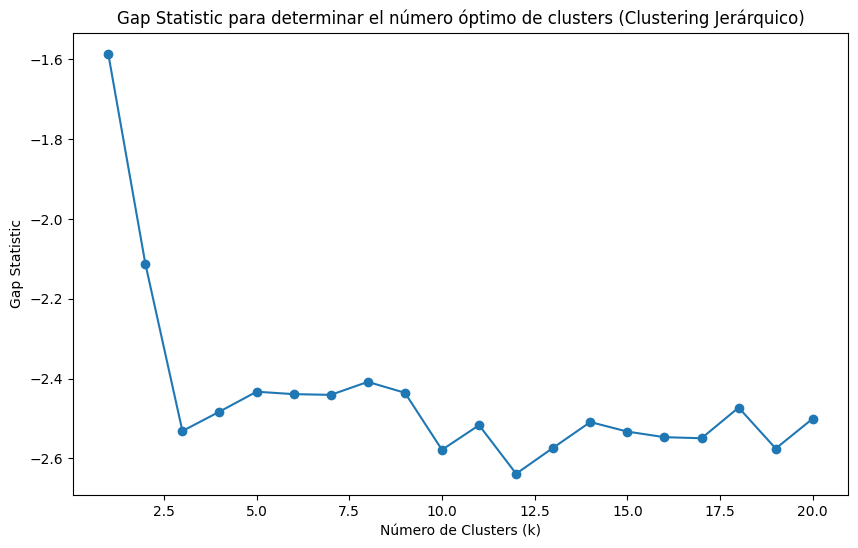

In [51]:
print("Número óptimo de clusters según el Gap Statistic:", optimal_k)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), gaps, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic para determinar el número óptimo de clusters (Clustering Jerárquico)')
plt.show()

El punto de clúster más óptimo es 4, ya que allí se produce una especie de "Codo". Un clúster igual a 1 no sería útil ya que se busca segmentar y no sería una opción adecuada al objetivo.

El valor de Gap Statistic disminuye significativamente hasta 4, lo que indica que para k=4, los clusters encontrados son significativamente distintos entre sí. Después de 4 clusters, el Gap Statistic se estabiliza y presenta una leve mejora para algunos valores más altos de, pero sin una ganancia sustancial.

A partir de k=5, hay una disminución notable en el Gap Statistic, lo que sugiere que agregar más clusters podría no mejorar mucho la estructura de los grupos y puede comenzar a sobreajustar los datos.

### Silhoutte

In [52]:
def calculate_silhouette(X_scaled, k, linkage='ward'):
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = clustering.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    sample_silhouette_values = silhouette_samples(X_scaled, labels)
    return silhouette_avg, sample_silhouette_values

avg_silhouette, sample_silhouette_values = calculate_silhouette(X_sub_sdd,4,linkage='ward')

In [53]:
avg_silhouette

0.4191634982547314

Un Silhouette Score de 0.4191 implica que el clustering tiene una calidad moderada, lo cual se visualizará e interpretará junto al gráfico en el siguiente apartado

### Mostrar con cluster optimo

In [54]:
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters)

cluster_assignments = clustering.fit_predict(X_sub_sdd)

df_X_sub_scaled = pd.DataFrame(X_sub_sdd, columns=df_sub.drop('Cultivo', axis = 1).columns)

df_X_sub_scaled['Cultivo'] = df_sub['Cultivo']

df_X_sub_scaled['Cluster'] = cluster_assignments

In [55]:
##Graficar clustering en 3d
fig = px.scatter_3d(
    X_sub_sdd, x = 0, y = 1, z = 2, color = df_X_sub_scaled['Cluster'], labels = {'color': 'Cluster'},
    hover_data={'Cultivo': df_X_sub_scaled['Cultivo'] }
)
fig.show()

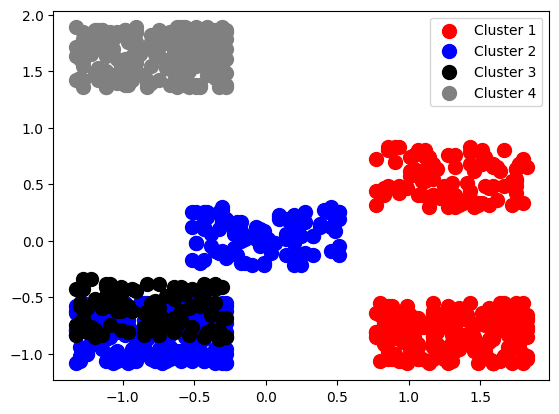

In [56]:
## Visualizar
hc = AgglomerativeClustering(n_clusters = 4,
 metric= 'euclidean',
 linkage = 'ward')
y_hc = hc.fit_predict(X_sub_sdd)
plt.scatter(X_sub_sdd[y_hc == 0, 0], X_sub_sdd[y_hc == 0, 1],
s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_sub_sdd[y_hc == 1, 0], X_sub_sdd[y_hc == 1, 1],
s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X_sub_sdd[y_hc == 2, 0], X_sub_sdd[y_hc == 2, 1],
s = 100, c = 'black', label = 'Cluster 3')
plt.scatter(X_sub_sdd[y_hc == 3, 0], X_sub_sdd[y_hc == 3, 1],
s = 100, c = 'grey', label = 'Cluster 4')
plt.legend()
plt.show()

Los clusters están separados lo suficientemente bien, pero hay cierto grado de superposición o confusión entre algunos puntos que podrían estar cercanos a los bordes de otros clusters, lo que sugiere que el Clustering Aglomerativo ha logrado una segmentación decente, pero es probable que haya espacio para mejorar.

El Silhouette Score de 0.4191 indica que el modelo de Clustering Aglomerativo ha capturado algunas estructuras en los datos, pero no de manera perfecta. Los clusters están moderadamente bien formados, aunque hay algunos puntos que están cerca de los límites o mal asignados.

# Conclusiones

A lo largo de todo el trabajo pudimos abordar distintos modelos de reducción de dimensionalidad, clústers y visualización de datos.
Pudimos observar que:
- Si se quiere observar los componentes principales y la distribución de los datos en cuanto a la variabilidad de los mismos, preservando la estructura global de los datos, reduciendo ruido, PCA es más acorde.
- Si se quiere visualizar la distribución de los datos manteniendo una relatividad en las distancias y capturando relaciones no lineales, ISOMAP es aquél que más se adecúa.
- A la hora de visualizar clústers preservando la estructura local, aquél más acorde es T-SNE. Además, es una excelente opción para la visualización en 2D o 3D, sobre todo si los datos no tienen una estructura lineal clara. Sin embargo, es más lento y no preserva distancias globales, lo que lo hace menos adecuado para reducir dimensionalidad en modelos predictivos.
- Si el objetivo es agrupar los datos en un número de clúster dado u optimizar el número de clusters basado en la dispersión de los datos. El adecuado es K-Means; es fácil de interpretar y aplicar.
- Si se busca agrupar los datos observando la estructura jerárquica de los datos, en un cierto número de clústers dado y de manera aglomerativa, Clústering Jerárquico Aglomerativo es el que se adecúa mejor a dicha tarea.



